# Demonstration of AEquitas

## Introduction

Today, I'll be demonstrating AEquitas. AEquitas is a A Deep Learning Based Metric for Detecting, Characterizing and Mitigating Dataset Bias. Diagnostic and prognostic algorithms can recapitulate and perpetuate systemic biases against underserved populations. Post-hoc technical solutions do not work well because they are unable to overcome biased data used to train algorithms. A more data-centric approach may help address bias earlier in the process of development of algorithms. We present AEquity (AEq), a sample-efficient deep-learning based metric, that measures the learnability of subsets of data representing underserved populations.

<div>
<img src="./img/Figure-1.png" width="700"/>
</div>

## Core concepts behind AEquity



**AEq pipeline in practice.** 

**(A)** The red and green outlines represent the labels. The gray represents a relatively homogenous group. A model is trained on what is thought to be a standard dataset and appears to perform well. 

**(B)** The red and green outlines represent different labels, while the gray represents the over-represented group while yellow represents the under-represented group. When naively trained in a similar manner on a more diverse dataset, the resulting model is biased because it performs worse for a particular group, because of systematic biases reflected in the data. 

**(C)** Application of AEquity enables disentanglement of dataset-level roots of the resulting bias. AEq is applied directly to the dataset and can generate values for each group and label. 

**(D)** Actionable feedback from AEquity reduces bias by improving performance for the disadvantaged group. Two types of actionable feedback are depicted – the blue and orange borders represent the selection of more informative labels. Second, the yellow and gray samples added to the dataset highlight a targeted dataset collection.

<div>
<img src="./img/Figure-2.png" width="700"/>
</div>

## Application to Social Bias


In a seminal paper published in *Science*, Obermeyer et al showed that racial bias in cost-predictive algorithms can propagate systemic forms of inequity in healthcare resource allocation. When using cost as the risk-derived metric, Black patients at a given risk score were considerably sicker than their white counterparts. This bias arises because the algorithm predicts health care costs rather than illness, but unequal access to care led to less being spent on care for Black patients. This bias arises despite using calibration-based fairness metrics and is invariant to including an indicator variable for “race.” Thus, traditional metrics are insufficient to capture the bias. On switching from a cost-based metric to one that utilizes comorbidities, the algorithm was able to mitigate some of the bias. 

We conducted an analysis utilizing AEq to replicate the results and conclusions of the dataset provided by the authors of Obermeyer et al (4). They showed that racial bias in cost-predictive algorithms can propagate systemic forms of inequity in health care resource allocation. Using cost as the risk-derived metric, Black patients at a given risk score were considerably sicker than their White counterparts. 

We calculated the difference in AEq values between each race for each metric. The model demonstrated that when using active chronic conditions as the outcome metric, the difference in AEq between Black and White patients was not statistically significantly different from zero in the high-risk group (P = 0.22). In contrast, when using cost-based metrics such as avoidable costs and total costs, the difference in AEq between Black and white patients was significantly greater than 0 (Ptotal cost = 6.49 x 10-10; Pavoidable costs= 1.67 x 10-10), consistent with generalizability differences across different races, which fits the definition of algorithmic label bias.

<div>
<img src="./img/Figure-5.png" width="700"/>
</div>

### Inspecting the Dataset

In [23]:
import pandas as pd
import seaborn as sns
import warnings

In [33]:
warnings.filterwarnings('ignore')
sns.set_theme(style="white", palette=None)

In [28]:
df = pd.read_csv("./preprocssed_demo.tsv", sep="\t")

In [29]:
df.head()

In [55]:
summmary_demographics = pd.DataFrame(df.groupby(['demographics', 'dem_female']).size())
summmary_demographics.reset_index(inplace=True)
summmary_demographics['count'] = summmary_demographics[0]

def assign_sex(value):
    if(value == 0): return "Male"
    else: return "Female"

def assign_race(value):
    if(value == 0): return "White"
    else: return "Black"
    
summmary_demographics['Sex'] =  summmary_demographics['dem_female'].apply(assign_sex)
summmary_demographics['Race'] =  summmary_demographics['demographics'].apply(assign_race)

summmary_demographics.head()

In [56]:
g = sns.catplot(
    data=summmary_demographics, kind="bar",
    x="Race", y="count", hue="Sex", palette="dark", alpha=.6, height=6
)

In [57]:
outcome_columns = ['log_cost_t', 'gagne_sum_t', 'log_cost_avoidable_t']

## Measure Biases

1. Install requirements.

These requirements are publicly sourced such as 

```{bash}
sklearn
torch
scipy
torchvision
pandas
```

```{bash}
pip install requirements.txt
```
And are also privately sourced: mainly cnnMCSE. 

In [1]:
from cnnMCSE.predict import measure_disparity_custom

/hpc/users/gulamf01/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2. Setup config file in a config.yaml file.

```{yaml}
# Contains path to data. Contains independent variables, demographics, and outcome variables. 
dataset_path: ./preprocssed_demo.tsv 

# Name of demographics variable in data_path.
demographics_cols: demographics

# Name of outcome variable in data_path
outcome_cols: log_cost_t  

# Name of columns to exclude in this analysis (irrelevant outcome columns).  
exclude_cols: gagne_sum_t,log_cost_avoidable_t,demographics 

# Output directory for AEq analyses. 
root_dir: ./output   

# Model type. Can select more complex models for more complex tasks. 
models: A3,FCN 

# Input Dimension
input_dim: 149 

# Hidden dimension hyper-parameter
hidden_size: 64 

# Use this function for more complicated image-based models like ResNet or AlexNet. 
zoo_models: None 

# Max sample size to calculate from. Usually only require 128-512 samples. 
max_sample_size: 5000 

# Number of bootstraps. 30-50 is typically recommended for resolution at 5000 samples. 
n_bootstraps: 30 

# Batch size. Increase with larger computers. 
batch_size: 1 
```

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from cnnMCSE.predict import measure_disparity_custom

/hpc/users/gulamf01/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [35]:
%%time
measure_disparity_custom(
    dataset_path = "./preprocssed_demo_demographics.tsv",
    demographics_cols = "demographics",
    outcome_cols = "log_cost_t",
    exclude_cols = "gagne_sum_t,log_cost_avoidable_t,demographics",
    models = "A3,FCN",
    n_bootstraps = 5,
    batch_size = 1,
    start_seed = 42,
    input_dim = 149,
    hidden_size = 64,
    max_sample_size = 5000,
    root_dir = "./output"
)

KeyboardInterrupt: 

In [36]:
metadata = pd.read_csv("./output/metadata.tsv", sep="\t")
metadata

,dataset,label,mean_mcse,sd_mcse,demographics,outcome,subset
0,Black__log_cost_t__train,0.0,6.2,0.014907,Black,log_cost_t,train
1,Black__log_cost_t__train,1.0,7.2,0.036515,Black,log_cost_t,train
2,White__log_cost_t__train,0.0,6.6,0.044721,White,log_cost_t,train
3,White__log_cost_t__train,1.0,6.8,0.014907,White,log_cost_t,train
4,joint__log_cost_t__train,0.0,6.8,0.027889,joint,log_cost_t,train
5,joint__log_cost_t__train,1.0,7.2,0.043461,joint,log_cost_t,train


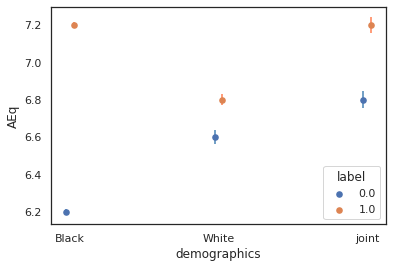

In [39]:
ax = sns.pointplot('demographics', 'mean_mcse', hue='label',
    data=metadata, dodge=True, join=False, ci=None, scale=0.75)

# Find the x,y coordinates for each point
x_coords = []
y_coords = []
for point_pair in ax.collections:
    for x, y in point_pair.get_offsets():
        x_coords.append(x)
        y_coords.append(y)
errors = metadata['sd_mcse']
colors = ['steelblue']*3 + ['coral']*3 
ax.errorbar(x_coords, y_coords, yerr=errors,
    ecolor=colors, fmt=' ', zorder=-1)
ax.set_ylabel("AEq")
plt.show()

In [2]:
%%time
measure_disparity_custom(
    dataset_path = "./preprocssed_demo_demographics.tsv",
    demographics_cols = "demographics",
    outcome_cols = "gagne_sum_t",
    exclude_cols = "log_cost_t,log_cost_avoidable_t,demographics",
    models = "A3,FCN",
    n_bootstraps = 5,
    batch_size = 1,
    start_seed = 42,
    input_dim = 149,
    hidden_size = 64,
    max_sample_size = 5000,
    root_dir = "./output/gagne"
)

/hpc/users/gulamf01/.local/lib/python3.6/site-packages/cnnMCSE-0.1-py3.6.egg/cnnMCSE/utils/helpers.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/hpc/users/gulamf01/.local/lib/python3.6/site-packages/cnnMCSE-0.1-py3.6.egg/cnnMCSE/utils/helpers.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/hpc/users/gulamf01/.local/lib/python3.6/site-packages/cnnMCSE-0.1-py3.6.egg/cnnMCSE/utils/helpers.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

CPU times: user 10min 45s, sys: 827 ms, total: 10min 46s
Wall time: 3min 10s


In [3]:
metadata = pd.read_csv("./output/gagne/metadata.tsv", sep="\t")
metadata

,dataset,label,mean_mcse,sd_mcse,demographics,outcome,subset
0,Black__gagne_sum_t__train,0.0,6.4,0.018257,Black,gagne_sum_t,train
1,Black__gagne_sum_t__train,1.0,7.2,0.043461,Black,gagne_sum_t,train
2,White__gagne_sum_t__train,0.0,6.8,0.043461,White,gagne_sum_t,train
3,White__gagne_sum_t__train,1.0,8.4,0.038006,White,gagne_sum_t,train
4,joint__gagne_sum_t__train,0.0,6.2,0.014907,joint,gagne_sum_t,train
5,joint__gagne_sum_t__train,1.0,6.6,0.018257,joint,gagne_sum_t,train


In [4]:
ax = sns.pointplot('demographics', 'mean_mcse', hue='label',
    data=metadata, dodge=True, join=False, ci=None, scale=0.75)

# Find the x,y coordinates for each point
x_coords = []
y_coords = []
for point_pair in ax.collections:
    for x, y in point_pair.get_offsets():
        x_coords.append(x)
        y_coords.append(y)
errors = metadata['sd_mcse']
colors = ['steelblue']*3 + ['coral']*3 
ax.errorbar(x_coords, y_coords, yerr=errors,
    ecolor=colors, fmt=' ', zorder=-1)
ax.set_ylabel("AEq")
plt.show()

NameError: name 'sns' is not defined

In [1]:
from cnnMCSE.predict import mitigate_disparity_custom

/hpc/users/gulamf01/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df, preds_df = mitigate_disparity_custom(
    dataset_path='./preprocssed_demo_demographics.tsv',
    demographics_cols = "demographics",
    outcome_cols = "log_cost_t,gagne_sum_t",
    exclude_cols = "log_cost_avoidable_t,demographics",
    root_dir = "./mitigate",
    models = "A3,FCN",
    input_dim = 149,
    hidden_size = 64,
    start_seed = 42,
    zoo_models = None,
    max_sample_size=128,
    sampler_mode=None,
    frequency=True,
    stratified=True,
    n_bootstraps=2,
    config=None,
    log_scale=2, 
    min_sample_size=16, 
    absolute_scale=False,
    batch_size=1,
    shuffle=True,
    num_workers=4,
    current_dataset="custom",
    metric_type="sAUC"
)

In [6]:
bootstraps_vector = [0, 1]

In [11]:
df2 = df[
    (df['demographics_test'] == "Black") &
    (df['sample_size'] == df['sample_size'].max())
]


df2 = df2.groupby(["sample_size", "demographics_train", "outcome_train"]).agg({
        "estimands": ["mean", "std"]
})
df2["auc_mean"] = df2["estimands"]["mean"]
df2["auc_sd"]   = df2["estimands"]["std"] / len(bootstraps_vector)
df2.drop(["estimands"], axis=1, inplace=True)
df2.reset_index(inplace=True)
df2

,sample_size,demographics_train,outcome_train,auc_mean,auc_sd
,,,,,
0,64,Black,gagne_sum_t,0.814981,0.000000
1,64,Black,log_cost_t,0.696111,0.000287
2,64,joint,gagne_sum_t,0.800557,0.008327
3,64,joint,log_cost_t,0.719735,0.008758


In [10]:
df

,label,s_estimands,estimands,bootstrap,sample_size,trainset,testset,demographics_train,outcome_train,subset_train,demographics_test,outcome_test,subset_test
0,0,0.499451,0.669920,0,16,White__log_cost_t__train,White__log_cost_t__test,White,log_cost_t,train,White,log_cost_t,test
0,1,0.509315,0.669920,0,16,White__log_cost_t__train,White__log_cost_t__test,White,log_cost_t,train,White,log_cost_t,test
0,0,0.499644,0.703995,1,16,White__log_cost_t__train,White__log_cost_t__test,White,log_cost_t,train,White,log_cost_t,test
0,1,0.509292,0.703995,1,16,White__log_cost_t__train,White__log_cost_t__test,White,log_cost_t,train,White,log_cost_t,test
0,0,0.493565,0.717111,0,32,White__log_cost_t__train,White__log_cost_t__test,White,log_cost_t,train,White,log_cost_t,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1,0.520972,0.734905,1,32,joint__gagne_sum_t__train,joint__gagne_sum_t__test,joint,gagne_sum_t,train,joint,gagne_sum_t,test
0,0,0.481031,0.812991,0,64,joint__gagne_sum_t__train,joint__gagne_sum_t__test,joint,gagne_sum_t,train,joint,gagne_sum_t,test
0,1,0.521571,0.812991,0,64,joint__gagne_sum_t__train,joint__gagne_sum_t__test,joint,gagne_sum_t,train,joint,gagne_sum_t,test
0,0,0.486365,0.797075,1,64,joint__gagne_sum_t__train,joint__gagne_sum_t__test,joint,gagne_sum_t,train,joint,gagne_sum_t,test
